In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import SEM, LinearDynamicSystem, KerasMultiLayerPerceptron

np.random.seed(345013)
sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


In [2]:
f_class = LinearDynamicSystem

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

t_horizon = 2

# specify the model architecture (makes a big difference! especially the training parameters)
# f_opts = dict(t=t_horizon, n_epochs=25, sgd_kwargs=sgd_kwargs,
#               n_hidden1=2, n_hidden2=2, 
#               hidden_act1='relu', hidden_act2='relu',
#               l2_regularization=0.05,
#               dropout=0.50)
f_opts = dict()

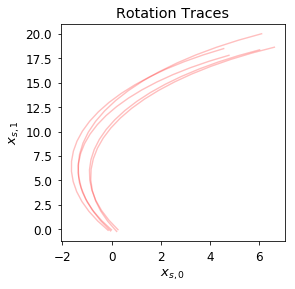

In [3]:
A = np.array([[-.5, -2], [2, -.2]])
A = np.random.randn(2, 2)

x0 = np.random.rand(2)
def rotate_matrix(theta):
    theta = theta /(180./np.pi)  # convert to radians
    W = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return W

def lds_update(x, b, W):
    return b + np.matmul(x, W)

n_samples = 5
x = []
fig = plt.figure(figsize=(4, 4))
for _ in range(n_samples):
    x0 = []
    x0.append(np.random.randn(2)*0.2)
    theta = 4.0 + np.random.randn() * 1.0
    b = np.array([-0.4, 1]) + np.random.randn(2) * 0.05
    for ii in range(20):
        x0.append(lds_update(x0[-1], b, rotate_matrix(4)))
        
    x0 = np.array(x0)
    plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25)
    x.append(x0)

plt.xlabel(r'$x_{s,0}$')
plt.ylabel(r'$x_{s,1}$')
plt.title('Rotation Traces')

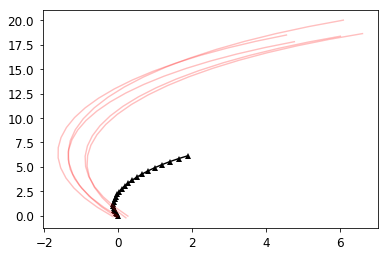

In [4]:
# train an event model (A Linear Dynamical System)
e = LinearDynamicSystem(D=2, eta=0.01)
from tqdm import tqdm_notebook

for x_samp in tqdm_notebook(x, total=n_samples):
    e.new_cluster()
    e.update_f0(x_samp[0, :])
    for ii in range(1, x_samp.shape[0] - 1):
        _x = x_samp[ii, :]
        _y = x_samp[ii+1, :]
        e.update(_x, _y)

        
# run the model generatively for each event
n_run = 25 # arbitray duration of the event to simluate
generative_samples = dict()

x0 = [np.reshape(e.predict_f0(), (1, 2))]
for t in range(1, n_run):
    x_ = np.concatenate(x0)[t-1, :]
#     x0.append(e.predict_next_generative(x_))
    x0.append(e.predict_next(x_).reshape(1, 2))
x0 = np.array(x0).reshape(-1, 2)

# for plotting I'm adding jitter to the locations
# x0 += np.random.randn(x0.shape[0], x0.shape[1]) * 0.1
plt.plot(x0[:, 0], x0[:, 1], '^-', color='k')

# plot the original LDS 
for x0  in x:
    plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25)

# the predicted points are the all near the end

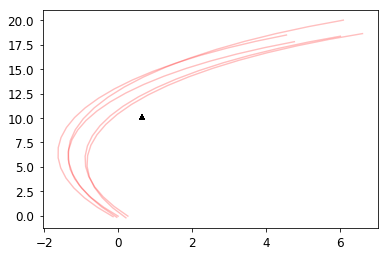

In [95]:
# train an event model (A Linear Dynamical System)
e = KerasMultiLayerPerceptron(D=2, l2_regularization=0.5, hidden_act='relu')
from tqdm import tqdm_notebook

for x_samp in tqdm_notebook(x, total=n_samples):
    e.new_cluster()
    e.update_f0(x_samp[0, :])
    for ii in range(1, x_samp.shape[0] - 1):
        _x = x_samp[ii, :]
        _y = x_samp[ii+1, :]
        e.update(_x, _y)

        
# run the model generatively for each event
n_run = 25 # arbitray duration of the event to simluate
generative_samples = dict()

x0 = [np.reshape(e.predict_f0(), (1, 2))]
for t in range(1, n_run):
    x_ = np.concatenate(x0)[t-1, :]
#     x0.append(e.predict_next_generative(x_))
    x0.append(e.predict_next(x_).reshape(1, 2))
x0 = np.array(x0).reshape(-1, 2)

# for plotting I'm adding jitter to the locations
# x0 += np.random.randn(x0.shape[0], x0.shape[1]) * 0.1
plt.plot(x0[:, 0], x0[:, 1], '^-', color='k')

# plot the original LDS 
for x0  in x:
    plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25)

# the predicted points are the all near the end

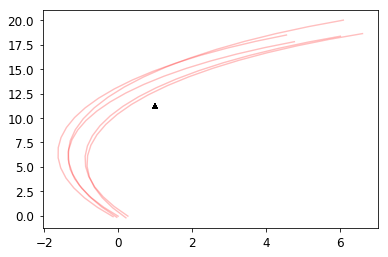

In [96]:
e.reestimate()

# run the model generatively for each event
n_run = 25 # arbitray duration of the event to simluate
generative_samples = dict()

x0 = [np.reshape(e.predict_f0(), (1, 2))]
for t in range(1, n_run):
    x_ = np.concatenate(x0)[t-1, :]
    x0.append(e.predict_next(x_).reshape(1, 2))
x0 = np.array(x0).reshape(-1, 2)

# for plotting I'm adding jitter to the locations
# x0 += np.random.randn(x0.shape[0], x0.shape[1]) * 0.1
plt.plot(x0[:, 0], x0[:, 1], '^-', color='k')

# plot the original LDS 
for x0  in x:
    plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25)

# the predicted points are the all near the end

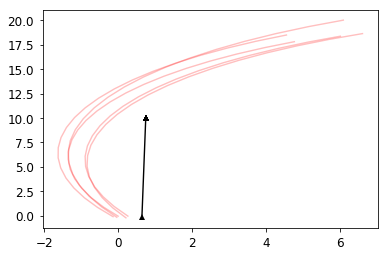

In [97]:
# plot the original LDS 
for x0 in x:
    plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25)

# pull a new event model
e._init_model()
mpl = e.model

# construct the training data set
x_all = []
y_all = []
for x_samp in x:
    x_all.append(np.zeros(2))
    y_all.append(x_samp[0, :])
    for ii in range(1, len(x_samp)):
        x_all.append(x_samp[ii-1, :])
        y_all.append(x_samp[ii, :])
x_all = np.array(x_all)
y_all = np.array(y_all)
mpl.fit(x_all, y_all, verbose=False, epochs=10, shuffle=True)

# # # run the model generatively for each event
n_run = 25 # arbitray duration of the event to simluate
generative_samples = dict()

x0 = [mlp.predict(np.zeros(2).reshape(1, 2))]
for t in range(1, n_run):
    x_ = np.concatenate(x0)[-1, :]
    x0.append(e.predict_next(x_).reshape(1, 2))
x0 = np.array(x0).reshape(-1, 2)

# for plotting I'm adding jitter to the locations
# x0 += np.random.randn(x0.shape[0], x0.shape[1]) * 0.1
plt.plot(x0[:, 0], x0[:, 1], '^-', color='k')



# # the predicted points are the all near the endmlp.

In [98]:
mpl.predict(np.random.randn(1, 2))

array([[  0.74328101,  10.05256176]], dtype=float32)

In [99]:
mpl.layers[0].get_weights()

[array([[-0.03150444, -0.0025923 ],
        [-0.36838874, -0.00188409]], dtype=float32),
 array([-2.58799267, -0.02669965], dtype=float32)]

In [100]:
mpl.layers[1].get_weights()

[array([[ 0.05936449,  0.17415293],
        [ 0.006324  ,  0.00492799]], dtype=float32),
 array([  0.74328101,  10.05256176], dtype=float32)]